# 🛠️ Define & Run Tools

In this notebook, we introduce the features we've developed for tool/function calling support in Haystack.

- We refactored the `ChatMessage` dataclass, to be more flexible and future-proof.
- We introduced some new dataclasses: `ToolCall`, `ToolCallResult`, and `Tool`.
- We added support for tools in the `OpenAIChatGenerator` and other Chat Generators.
- We introduced the `ToolInvoker` component, to actually execute tool calls prepared by Language Models.

We will first introduce the new features and then show two examples:
- A basic assistant that can answer user questions by either using a weather tool or relying on its own knowledge.
- A refined version of the assistant that can process the tool's output further before presenting it to the user.

For a more complex example, involving multiple tools and a Human-in-the-Loop interaction, check out this tutorial: [Building a Chat Agent with Function Calling](https://haystack.deepset.ai/tutorials/40_building_chat_application_with_function_calling).

In [ ]:
! pip install haystack-ai "sentence-transformers>=3.0.0"

In [15]:
import os
from getpass import getpass
from rich import print

if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

## New experimental features

### Refactored `ChatMessage` dataclass, `ToolCall`, and `ToolCallResult`

The `ChatMessage` dataclass has been updated so that the `content` field is no longer just a string (`str`); it is now a list that can hold various types, including `TextContent`, `ToolCall`, and `ToolCallResult`.

The class methods `from_user`, `from_system`, `from_assistant`, and `from_tool` (newly added) are the recommended ways to create `ChatMessage` instances.

Additionally, we introduced:
- `ToolCall` dataclass: represents a tool call prepared by a Language Model.
- `ToolCallResult` dataclass: represents the result of a tool invocation.

Let's see some examples.

In [16]:
from haystack.dataclasses import ChatMessage, ToolCall

user_message = ChatMessage.from_user("What is the capital of Australia?")
print(user_message)

print(user_message.text)
print(user_message.texts)

print(user_message.tool_call)
print(user_message.tool_calls)

print(user_message.tool_call_result)
print(user_message.tool_call_results)

ChatMessage(
    _role=<ChatRole.USER: 'user'>,
    _content=[TextContent(text='What is the capital of Australia?')],
    _meta={}
)

What is the capital of Australia?

['What is the capital of Australia?']

None

[]

None

[]

In [17]:
assistant_message = ChatMessage.from_assistant("How can I assist you today?")
print(assistant_message)

print(assistant_message.text)
print(assistant_message.texts)

print(assistant_message.tool_call)
print(assistant_message.tool_calls)

print(assistant_message.tool_call_result)
print(assistant_message.tool_call_results)

ChatMessage(
    _role=<ChatRole.ASSISTANT: 'assistant'>,
    _content=[TextContent(text='How can I assist you today?')],
    _meta={}
)

How can I assist you today?

['How can I assist you today?']

None

[]

None

[]

In [18]:
tool_call = ToolCall(tool_name="weather_tool", arguments={"location": "Rome"})

assistant_message_w_tool_call = ChatMessage.from_assistant(tool_calls=[tool_call])

print(assistant_message_w_tool_call.text)
print(assistant_message_w_tool_call.texts)

print(assistant_message_w_tool_call.tool_call)
print(assistant_message_w_tool_call.tool_calls)

print(assistant_message_w_tool_call.tool_call_result)
print(assistant_message_w_tool_call.tool_call_results)

None

[]

ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None)

[ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None)]

None

[]

In [19]:
tool_message = ChatMessage.from_tool(tool_result="temperature: 25°C", origin=tool_call, error=False)

print(tool_message.text)
print(tool_message.texts)

print(tool_message.tool_call)
print(tool_message.tool_calls)

print(tool_message.tool_call_result)
print(tool_message.tool_call_results)

None

[]

None

[]

ToolCallResult(
    result='temperature: 25°C',
    origin=ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None),
    error=False
)

[
    ToolCallResult(
        result='temperature: 25°C',
        origin=ToolCall(tool_name='weather_tool', arguments={'location': 'Rome'}, id=None),
        error=False
    )
]

### `Tool` dataclass

This represents a tool for which Language Models can prepare a call.

It has the following attributes:
- `name`
- `description`
- `parameters`: a JSON schema describing the expected parameters
- `function`: a callable that is invoked when the tool is called

Accurate definitions of the textual attributes such as `name` and `description` are important for the Language Model to correctly prepare the call.

`Tool` exposes a `tool_spec` property, returning the tool specification to be used by Language Models.

It also has an `invoke` method that executes the underlying function with the provided parameters.

Let's see an example.

In [20]:
from haystack.tools import Tool

def add(a: int, b: int) -> int:
    return a + b


parameters = {
    "type": "object",
    "properties": {
        "a": {"type": "integer"},
        "b": {"type": "integer"}
    },
    "required": ["a", "b"]
}

add_tool = Tool(name="addition_tool",
            description="This tool adds two numbers",
            parameters=parameters,
            function=add)

print(add_tool.tool_spec)

print(add_tool.invoke(a=15, b=10))

{
    'name': 'addition_tool',
    'description': 'This tool adds two numbers',
    'parameters': {
        'type': 'object',
        'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}},
        'required': ['a', 'b']
    }
}

25

### Support for tools in `OpenAIChatGenerator`

The `OpenAIChatGenerator` now supports tools. You can pass tools during initialization or via the `run` method, and it will use them to prepare tool calls when appropriate.

Here are some examples.

In [21]:
from haystack.components.generators.chat import OpenAIChatGenerator

# Initialize the Chat Generator with the addition tool
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini", tools=[add_tool])

res=chat_generator.run([ChatMessage.from_user("10 + 238")])
print(res)

res=chat_generator.run([ChatMessage.from_user("What is the habitat of a lion?")])
print(res)

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[
                ToolCall(
                    tool_name='addition_tool',
                    arguments={'a': 10, 'b': 238},
                    id='call_rbYtbCdW0UbWMfy2x0sgF1Ap'
                )
            ],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'tool_calls',
                'usage': {'completion_tokens': 19, 'prompt_tokens': 51, 'total_tokens': 70}
            }
        )
    ]
}

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[
                TextContent(
                    text='Lions primarily inhabit grasslands, savannas, and open woodlands. They are generally 
found in sub-Saharan Africa, where they prefer areas that provide ample prey and suitable shelter. Historically, 
lions were also present in parts of Europe and Asia, but their range has significantly diminished, and they are now
largely confined to Africa. The presence of water sources and accessible prey are critical factors in their habitat
selection.'
                )
            ],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'stop',
                'usage': {'completion_tokens': 84, 'prompt_tokens': 55, 'total_tokens': 139}
            }
        )
    ]
}

In [22]:
# Initialize the Chat Generator without tools
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini")

res=chat_generator.run([ChatMessage.from_user("10 + 238")])
print(res)

# pass tools in the run method: in this case, the model will prepare a tool call
res_w_tool_call=chat_generator.run([ChatMessage.from_user("10 + 238")], tools=[add_tool])
print(res_w_tool_call)

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[TextContent(text='10 + 238 = 248.')],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'stop',
                'usage': {'completion_tokens': 8, 'prompt_tokens': 11, 'total_tokens': 19}
            }
        )
    ]
}

{
    'replies': [
        ChatMessage(
            _role=<ChatRole.ASSISTANT: 'assistant'>,
            _content=[
                ToolCall(
                    tool_name='addition_tool',
                    arguments={'a': 10, 'b': 238},
                    id='call_GaVZnGszepASznKpYVe23mHf'
                )
            ],
            _meta={
                'model': 'gpt-4o-mini-2024-07-18',
                'index': 0,
                'finish_reason': 'tool_calls',
                'usage': {'completion_tokens': 19, 'prompt_tokens': 51, 'total_tokens': 70}
            }
        )
    ]
}

### `ToolInvoker` component

This component is responsible for executing tool calls prepared by Language Models.
It expects a list of messages (which may include tool calls) and returns a list of tool messages, containing the results of the tool invocations.

In [23]:
from haystack.components.tools import ToolInvoker

# Initialize the Tool Invoker with the weather tool
tool_invoker = ToolInvoker(tools=[add_tool])

# let's pass the messages from the previous example
print(tool_invoker.run(res_w_tool_call["replies"]))

{
    'tool_messages': [
        ChatMessage(
            _role=<ChatRole.TOOL: 'tool'>,
            _content=[
                ToolCallResult(
                    result='248',
                    origin=ToolCall(
                        tool_name='addition_tool',
                        arguments={'a': 10, 'b': 238},
                        id='call_GaVZnGszepASznKpYVe23mHf'
                    ),
                    error=False
                )
            ],
            _meta={}
        )
    ]
}

`ToolInvoker` has 2 additional init parameters:
- `raise_on_failure`: if True, the component raises an exception in case of errors (tool not found, tool invocation errors, tool result conversion errors). Otherwise, it returns a `ChatMessage` object with `error=True` and a description of the error in `result`.
- `convert_result_to_json_string`: if True, the tool invocation result will be converted to a string using `json.dumps`. If False, converts the result using `str` (default).

Let's see how `raise_on_failure` works.

In [24]:
tool_call = ToolCall(tool_name="division_tool", arguments={"c": 1, "d": 2})

tool_invoker = ToolInvoker(tools=[add_tool], raise_on_failure=True)

tool_invoker.run([ChatMessage.from_assistant(tool_calls=[tool_call])])

ToolNotFoundException: Tool division_tool not found in the list of tools. Available tools are: dict_keys(['addition_tool']).

In [26]:
tool_invoker = ToolInvoker(tools=[add_tool], raise_on_failure=False)

print(tool_invoker.run([ChatMessage.from_assistant(tool_calls=[tool_call])]))

{
    'tool_messages': [
        ChatMessage(
            _role=<ChatRole.TOOL: 'tool'>,
            _content=[
                ToolCallResult(
                    result="Tool division_tool not found in the list of tools. Available tools are: 
dict_keys(['addition_tool']).",
                    origin=ToolCall(tool_name='division_tool', arguments={'c': 1, 'd': 2}, id=None),
                    error=True
                )
            ],
            _meta={}
        )
    ]
}

## End-to-end examples

In this section, we’ll put together everything we've covered so far into some practical, end-to-end examples.

### A simple use case

We'll start by creating a basic assistant that can answer user questions by either using a weather tool or relying on its own knowledge.

In [27]:
# Define a dummy weather tool

import random

def dummy_weather(location: str):
    return {"temp": f"{random.randint(-10, 40)} °C",
            "humidity": f"{random.randint(0, 100)}%"}


weather_tool = Tool(
    name="weather",
    description="A tool to get the weather",
    function=dummy_weather,
    parameters={
        "type": "object",
        "properties": {"location": {"type": "string"}},
        "required": ["location"],
    },
)

In [28]:
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.tools import ToolInvoker

# Initialize the Chat Generator with the weather tool
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool])

# Initialize the Tool Invoker with the weather tool
tool_invoker = ToolInvoker(tools=[weather_tool])

In [29]:
user_message = ChatMessage.from_user("What is the weather in Berlin?")

replies = chat_generator.run(messages=[user_message])["replies"]
print(f"assistant messages: {replies}")

# If the assistant message contains a tool call, run the tool invoker
if replies[0].tool_calls:
    tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
    print(f"tool messages: {tool_messages}")

assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[ToolCall(tool_name='weather', 
arguments={'location': 'Berlin'}, id='call_YEvCEAmlvc42JGXV84NU8wtV')], _meta={'model': 'gpt-4o-mini-2024-07-18', 
'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 13, 'prompt_tokens': 50, 'total_tokens': 
63}})]

tool messages: [ChatMessage(_role=<ChatRole.TOOL: 'tool'>, _content=[ToolCallResult(result="{'temp': '22 °C', 
'humidity': '35%'}", origin=ToolCall(tool_name='weather', arguments={'location': 'Berlin'}, 
id='call_YEvCEAmlvc42JGXV84NU8wtV'), error=False)], _meta={})]

The assistant correctly identifies when a tool is needed to answer a question and calls the appropriate tool.

In [30]:
user_message = ChatMessage.from_user("What is the capital of Australia?")

replies = chat_generator.run(messages=[user_message])["replies"]
print(f"assistant messages: {replies}")

# If the assistant message contains a tool call, run the tool invoker
if replies[0].tool_calls:
    tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
    print(f"tool messages: {tool_messages}")

assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The capital 
of Australia is Canberra.')], _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 
'usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58}})]

This time, the assistant uses its internal knowledge to answer the question.

#### Using a Pipeline

To achieve similar functionality using a Pipeline, we'll introduce a [Conditional Router](https://docs.haystack.deepset.ai/docs/conditionalrouter) that directs the flow based on whether the reply contain a tool call or not.

/usr/local/lib/python3.10/dist-packages/haystack/components/routers/conditional_router.py:141: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


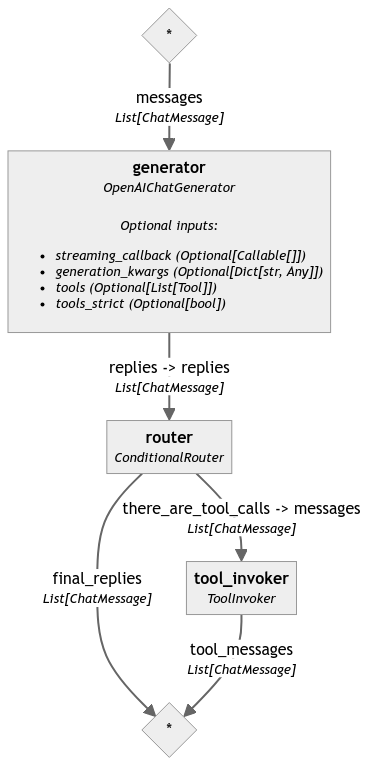

In [31]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from typing import List

routes = [
    {
        "condition": "{{replies[0].tool_calls | length > 0}}",
        "output": "{{replies}}",
        "output_name": "there_are_tool_calls",
        "output_type": List[ChatMessage],
    },
    {
        "condition": "{{replies[0].tool_calls | length == 0}}",
        "output": "{{replies}}",
        "output_name": "final_replies",
        "output_type": List[ChatMessage],
    },
]

tools_pipe = Pipeline()
tools_pipe.add_component("generator", OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool]))
tools_pipe.add_component("router", ConditionalRouter(routes, unsafe=True))
tools_pipe.add_component("tool_invoker", ToolInvoker(tools=[weather_tool]))


tools_pipe.connect("generator.replies", "router")
tools_pipe.connect("router.there_are_tool_calls", "tool_invoker")

tools_pipe.show()

In [32]:
res=tools_pipe.run({"messages":[ChatMessage.from_user("What is the capital of Australia?")]})
print(res)

print("-"*50)

res=tools_pipe.run({"messages":[ChatMessage.from_user("What is the weather in Berlin?")]})
print(res)

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[TextContent(text='The capital of Australia is Canberra.')],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58}
                }
            )
        ]
    }
}

--------------------------------------------------

{
    'tool_invoker': {
        'tool_messages': [
            ChatMessage(
                _role=<ChatRole.TOOL: 'tool'>,
                _content=[
                    ToolCallResult(
                        result="{'temp': '7 °C', 'humidity': '46%'}",
                        origin=ToolCall(
                            tool_name='weather',
                            arguments={'location': 'Berlin'},
                            id='call_q3KA4O62IBLfOljuUKVPzdxy'
                        ),
                        error=False
                    )
                ],
                _meta={}
            )
        ]
    }
}

In this example, in case of tool calls, we end up with the raw tool invocation result, wrapped in a `ChatMessage` from tool role.
In the next example, we will see how to process this result further.

### Processing tool results with the Chat Generator

Depending on our use case and the tools involved, we might want to further process the tool's output before presenting it to the user. This can make the response more user-friendly.

In the next example, we'll pass the tool's response back to the Chat Generator for final processing.

In [33]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool])
tool_invoker = ToolInvoker(tools=[weather_tool])

user_message = ChatMessage.from_user("What is the weather in Berlin?")

replies = chat_generator.run(messages=[user_message])["replies"]
print(f"assistant messages: {replies}")

if replies[0].tool_calls:

    tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
    print(f"tool messages: {tool_messages}")

    # we pass all the messages to the Chat Generator
    messages = [user_message] + replies + tool_messages
    final_replies = chat_generator.run(messages=messages)["replies"]
    print(f"final assistant messages: {final_replies}")

assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[ToolCall(tool_name='weather', 
arguments={'location': 'Berlin'}, id='call_jHX0RCDHRKX7h8V9RrNs6apy')], _meta={'model': 'gpt-4o-mini-2024-07-18', 
'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 13, 'prompt_tokens': 50, 'total_tokens': 
63}})]

tool messages: [ChatMessage(_role=<ChatRole.TOOL: 'tool'>, _content=[ToolCallResult(result="{'temp': '2 °C', 
'humidity': '15%'}", origin=ToolCall(tool_name='weather', arguments={'location': 'Berlin'}, 
id='call_jHX0RCDHRKX7h8V9RrNs6apy'), error=False)], _meta={})]

final assistant messages: [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='The 
current weather in Berlin is 2 °C with a humidity level of 15%.')], _meta={'model': 'gpt-4o-mini-2024-07-18', 
'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 19, 'prompt_tokens': 85, 'total_tokens': 
104}})]

The assistant refines the tool's output to create a more human-readable response.

#### Using a Pipeline

The Pipeline is similar to the previous one.

We introduce a custom component, `MessageCollector`, to temporarily store the messages.

In [34]:
from typing import Any, Dict, List
from haystack import component
from haystack.core.component.types import Variadic

@component()
class MessageCollector:
    def __init__(self):
        self._messages = []

    @component.output_types(messages=List[ChatMessage])
    def run(self, messages: Variadic[List[ChatMessage]]) -> Dict[str, Any]:

        self._messages.extend([msg for inner in messages for msg in inner])
        return {"messages": self._messages}

    def clear(self):
        self._messages = []

message_collector = MessageCollector()

In [35]:
routes = [
    {
        "condition": "{{replies[0].tool_calls | length > 0}}",
        "output": "{{replies}}",
        "output_name": "there_are_tool_calls",
        "output_type": List[ChatMessage],
    },
    {
        "condition": "{{replies[0].tool_calls | length == 0}}",
        "output": "{{replies}}",
        "output_name": "final_replies",
        "output_type": List[ChatMessage],
    },
]

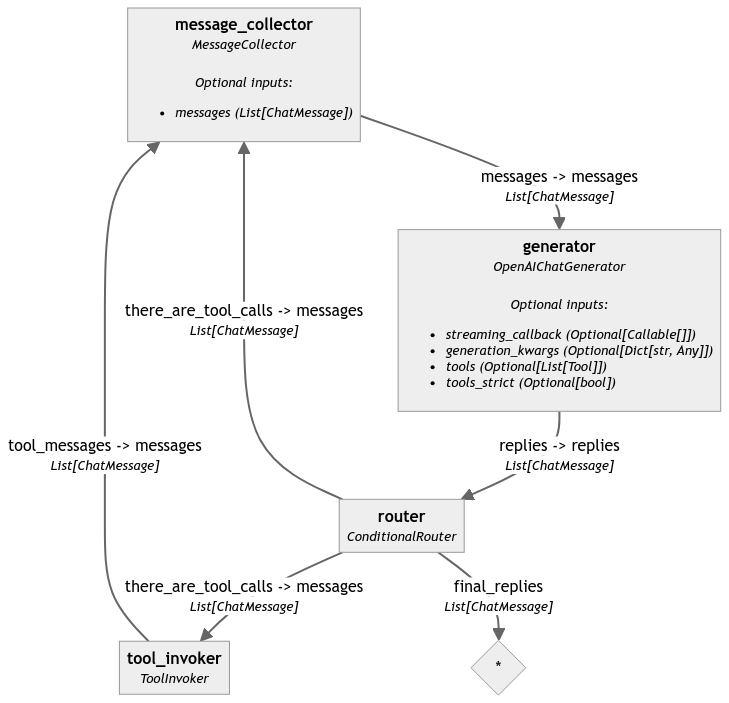

In [36]:
tool_agent = Pipeline()
tool_agent.add_component("message_collector", message_collector)
tool_agent.add_component("generator", OpenAIChatGenerator(model="gpt-4o-mini", tools=[weather_tool]))
tool_agent.add_component("router", ConditionalRouter(routes, unsafe=True))
tool_agent.add_component("tool_invoker", ToolInvoker(tools=[weather_tool]))


tool_agent.connect("message_collector", "generator.messages")
tool_agent.connect("generator.replies", "router")
tool_agent.connect("router.there_are_tool_calls", "tool_invoker")
tool_agent.connect("router.there_are_tool_calls", "message_collector")
tool_agent.connect("tool_invoker.tool_messages", "message_collector")

tool_agent.show()

In [37]:
message_collector.clear()
res=tool_agent.run({"messages":[ChatMessage.from_user("What is the capital of Australia?")]})
print(res)

print("-"*50)

message_collector.clear()
res=tool_agent.run({"messages":[ChatMessage.from_user("What is the weather in Berlin?")]})
print(res)

print("-"*50)

message_collector.clear()
res=tool_agent.run({"messages":[ChatMessage.from_user("What is the weather in Rome and Bangkok?")]})
print(res)

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[TextContent(text='The capital of Australia is Canberra.')],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 8, 'prompt_tokens': 50, 'total_tokens': 58}
                }
            )
        ]
    }
}

--------------------------------------------------

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[TextContent(text='The current weather in Berlin is 9 °C with a humidity of 40%.')],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 18, 'prompt_tokens': 85, 'total_tokens': 103}
                }
            )
        ]
    }
}

--------------------------------------------------

{
    'router': {
        'final_replies': [
            ChatMessage(
                _role=<ChatRole.ASSISTANT: 'assistant'>,
                _content=[
                    TextContent(
                        text='The current weather is as follows:\n\n- **Rome**: Temperature is 31 °C with 80% 
humidity.\n- **Bangkok**: Temperature is 20 °C with 23% humidity.'
                    )
                ],
                _meta={
                    'model': 'gpt-4o-mini-2024-07-18',
                    'index': 0,
                    'finish_reason': 'stop',
                    'usage': {'completion_tokens': 43, 'prompt_tokens': 147, 'total_tokens': 190}
                }
            )
        ]
    }
}

For a more complex example, involving multiple tools and a Human-in-the-Loop interaction, check out this tutorial: [Building a Chat Agent with Function Calling](https://haystack.deepset.ai/tutorials/40_building_chat_application_with_function_calling).